In [8]:
import contextily as cx
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from collections import namedtuple
from matplotlib.colors import Normalize 
from dotenv import load_dotenv
import geopandas

import argparse
import pandas as pd
import pprint

from pathlib import Path
import sys, os

%load_ext autoreload
%autoreload 2

project_root = Path.cwd().parent
while project_root.stem != 'archeo-geo-graph':
    project_root = project_root.parent

sys.path.append(str(project_root))
data = project_root / 'data'
print(f"Project root directory: {project_root}")
print(f"Data directory: {data}")
load_dotenv()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Project root directory: /home/dmtr/code/archeo-geo-graph
Data directory: /home/dmtr/code/archeo-geo-graph/data


True

In [9]:
def parse_coordinates(file_name):
    df = pd.read_csv(file_name, sep=';', index_col='Node')
    return df.T.to_dict()

In [10]:
def parse_imports(node_coordinates, file_name, century):

    df = pd.read_csv(file_name, sep=';')
    df_for_century = df.dropna(subset=[str(century)])

    # collect all nodes in a set
    node_names = set(df_for_century['Source node']).union(df_for_century['Target node'])
    nodes = {}
    for node_name in node_names:
        coordinates = node_coordinates.get(node_name) #the location of the nodes in a coordinate value
        if not coordinates:
            raise RuntimeError(f"Node name {node_name} not found in coordinates file")
        nodes[node_name] = float(coordinates['E']), float(coordinates['N']) 

    edges = df_for_century.loc[:, ['Source node', 'Target node', 'Quantity', '% of imports for site per century', '% of all pottery for site per century']]
    Edge = namedtuple('Edge', ['source', 'target', 'quantity', 'percent_imports', 'percent_of_all_for_site'])
    edges = [Edge(source=r[0], target=r[1], quantity=int(r[2]), percent_imports=float(r[3]), percent_of_all_for_site=float(r[4])) for r in edges.to_numpy()]

    return nodes, edges

In [11]:
node_coordinates = parse_coordinates(data / "Coordinates.csv")

In [12]:
nodes, edges = parse_imports(node_coordinates, data / "imports_percent_combined_version4.csv", 15)

In [13]:
nodes

{'Valencia_Spain': (-0.37966, 39.47391),
 'Northwest_Anatolia': (29.90424, 39.99395),
 'Ephesus': (27.36849, 37.95137),
 'Sofia': (23.32415, 42.69751),
 'Mytilini': (26.55529, 39.10772),
 'Varna': (27.91667, 43.21667),
 'Levant': (36.0, 34.0),
 'Italian_States': (12.83333, 42.83333)}

In [14]:
edges

[Edge(source='Northwest_Anatolia', target='Sofia', quantity=9, percent_imports=47.4, percent_of_all_for_site=24.6),
 Edge(source='Valencia_Spain', target='Sofia', quantity=2, percent_imports=10.5, percent_of_all_for_site=5.5),
 Edge(source='Ephesus', target='Sofia', quantity=6, percent_imports=31.6, percent_of_all_for_site=16.4),
 Edge(source='Italian_States', target='Sofia', quantity=2, percent_imports=10.5, percent_of_all_for_site=5.5),
 Edge(source='Northwest_Anatolia', target='Varna', quantity=1, percent_imports=50.0, percent_of_all_for_site=8.8),
 Edge(source='Italian_States', target='Varna', quantity=1, percent_imports=50.0, percent_of_all_for_site=8.8),
 Edge(source='Northwest_Anatolia', target='Mytilini', quantity=7, percent_imports=87.5, percent_of_all_for_site=16.9),
 Edge(source='Levant', target='Mytilini', quantity=1, percent_imports=12.5, percent_of_all_for_site=2.4)]

In [15]:
nodes

{'Valencia_Spain': (-0.37966, 39.47391),
 'Northwest_Anatolia': (29.90424, 39.99395),
 'Ephesus': (27.36849, 37.95137),
 'Sofia': (23.32415, 42.69751),
 'Mytilini': (26.55529, 39.10772),
 'Varna': (27.91667, 43.21667),
 'Levant': (36.0, 34.0),
 'Italian_States': (12.83333, 42.83333)}

In [16]:
# find cities related to mytilini
mytilininodes = []
mytiliniedges = []
for e in edges:
    if e.source=='Mytilini' or e.target=='Mytilini':
        if e.source not in mytilininodes:
            mytilininodes.append(e.source)
        if e.target not in mytilininodes:
            mytilininodes.append(e.target)
        mytiliniedges.append((e.source, e.target, {"source": e.source,
        "target": e.target,
        "quantity": e.quantity,
        "percent_imports": e.percent_imports,
        "percent_of_all_for_site": e.percent_of_all_for_site}))

mnodes = {}
for node in mytilininodes:
    mnodes.update({node : nodes[node]})

print(mnodes)
print(mytilininodes)
[print(e) for e in mytiliniedges]

{'Northwest_Anatolia': (29.90424, 39.99395), 'Mytilini': (26.55529, 39.10772), 'Levant': (36.0, 34.0)}
['Northwest_Anatolia', 'Mytilini', 'Levant']
('Northwest_Anatolia', 'Mytilini', {'source': 'Northwest_Anatolia', 'target': 'Mytilini', 'quantity': 7, 'percent_imports': 87.5, 'percent_of_all_for_site': 16.9})
('Levant', 'Mytilini', {'source': 'Levant', 'target': 'Mytilini', 'quantity': 1, 'percent_imports': 12.5, 'percent_of_all_for_site': 2.4})


[None, None]

In [17]:
print('mnodes/positions:', mnodes)
print('mytilinyedges:', mytiliniedges)

mnodes/positions: {'Northwest_Anatolia': (29.90424, 39.99395), 'Mytilini': (26.55529, 39.10772), 'Levant': (36.0, 34.0)}
mytilinyedges: [('Northwest_Anatolia', 'Mytilini', {'source': 'Northwest_Anatolia', 'target': 'Mytilini', 'quantity': 7, 'percent_imports': 87.5, 'percent_of_all_for_site': 16.9}), ('Levant', 'Mytilini', {'source': 'Levant', 'target': 'Mytilini', 'quantity': 1, 'percent_imports': 12.5, 'percent_of_all_for_site': 2.4})]


label positions:

{'Northwest_Anatolia': (29.90424, 40.293949999999995), 'Mytilini': (26.55529, 39.40772), 'Levant': (36.0, 34.3)}


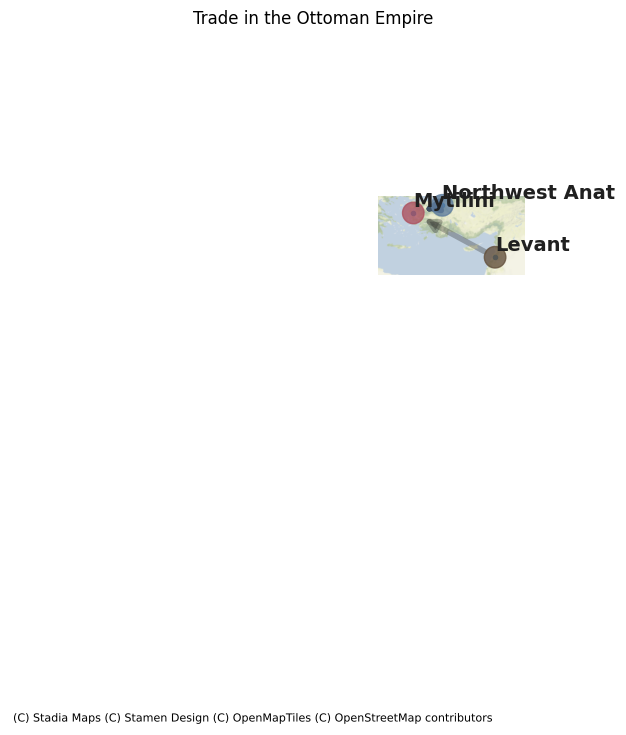

In [18]:
G = nx.DiGraph()
G.add_nodes_from(mytilininodes)
G.add_edges_from(mytiliniedges)

positions = mnodes

# put the location of the nodes as coordinates on the map
from shapely.geometry import Point
cities, geometry = zip(*list(mnodes.items()))
d = {'city': cities, 'geometry': list(map(Point, geometry))}
gdf = geopandas.GeoDataFrame(d, crs="WGS84")

# plot with a nice basemap
ax = gdf.plot(marker=".", figsize=(9,9))

provider = cx.providers.Stadia.StamenTerrainBackground(api_key=os.getenv('STAMEN_API_KEY'))
provider["url"] = provider["url"] + "?api_key={api_key}"


try:  # For issues with downloading/parsing basemaps in CI
    cx.add_basemap(ax, crs=gdf.crs, source=provider, zoom=6, alpha=0.6)
except:
    print("Could not add basemap")
    pass
ax.set_title("Trade in the Ottoman Empire")
ax.axis("off")
ax.set_xlim(-20, 50)
ax.set_ylim(-20, 60)

#change the colour of the nodes for only some nodes - blue for local source nodes, red for target nodes
node_colors = {'Sofia': ('#AD5260'), 'Belgrade': ('#AD5260'), 'Varna': ('#AD5260'), 'Izmir': ('#AD5260'), 'Mytilini': ('#AD5260'), 'Northwest_Anatolia':('#607E9F'), 
'Northwest_Anatolia':('#607E9F'), 'Chanakkale':('#607E9F'), 'Didymoteicho':('#607E9F'), 'Levantt':('#607E9F'), 'Ephesus':('#607E9F')}
node_color_list = [('#64513D')] * len(G.nodes()) #colour for the rest of the nodes

# Create a mapping from nodes for the colouring
for i, node in enumerate(G.nodes()):
    if node in node_colors:
        node_color_list[i] = node_colors[node]  

#draw network nodes
nx.draw_networkx_nodes(G, positions, node_color=node_color_list, 
        node_size=240, alpha=0.8,)

#change the colour of the edges
edge_colors = []
for edge in G.edges():
    source, target = edge
    if source in {"Northwest_Anatolia", "Chanakkale", "Didymoteicho", "Levantt", "Ephesus"}:
        edge_colors.append('#3D5064')  
    else:
        edge_colors.append('#202020')  

#draw network edges
min_alpha, max_alpha = 0.3, 1.0 #setting the min and max alpha for this attribute

percent_import_values = np.array([data['percent_imports'] for _, _, data in G.edges(data=True)]) #preparing the percent_import data to be normalised
norm = Normalize(vmin=percent_import_values.min(), vmax=percent_import_values.max())

edge_alphas = [min_alpha + (max_alpha - min_alpha) * norm(data['percent_imports']) for _, _, data in G.edges(data=True)] # creating an array for the alpha

nx.draw_networkx_edges(G, positions, edge_color=edge_colors, width=4, alpha=edge_alphas, arrows=True, arrowsize=17)

#change the labels for the nodes
labels_new = {'Kutahya':'Kütahya','Abisola_Italy':'Abisola', 'Central_Europe':'Central Europe', 'Valencia_Spain':'Valencia','Florence_Italy':'Florence',
            'Faenza_Italy':'Faenza', 'Iznik/Kutahya':'Iznik/Kütahya', 'Orvieto_Italy':'Orvieto', 'Tuscany_Italy':'Tuscany', 'West_Europe':'West Europe', 
            'South_Italy':'South Italy','Italian_States':'Italian States', 'Northwest_Anatolia':'Northwest Anatolia', 'German_States':'German States'}

current_nodes = {str(node): node for node in G.nodes()}

labels_to_draw = {}
for node in current_nodes:
    if node in labels_new:
        labels_to_draw[node] = labels_new[node]
    else:
        labels_to_draw[node] = node

label_positions = {node: (pos[0], pos[1] + 0.3) for node, pos in positions.items()}
print('label positions:\n')
print(label_positions)
#label_positions['Didymoteicho'] = (label_positions['Didymoteicho'][0] - 0.4, label_positions['Didymoteicho'][1] + 0.0)
#label_positions['Chanakkale'] = (label_positions['Chanakkale'][0] - 1, label_positions['Chanakkale'][1] + 0.0)
#label_positions['Vienna'] = (label_positions['Vienna'][0] - 2.5, label_positions['Vienna'][1] + 0.2)



#draw network labels
nx.draw_networkx_labels(G, label_positions, labels=labels_to_draw, font_size=14, font_color=('#202020'), font_weight='bold', 
horizontalalignment='left', verticalalignment='bottom') 

#draw edge labels for China - manually fix for each century, unfortunately

edges_to_hide = [ ('China', 'Belgrade'), ('China', 'Sofia'), ('China','Izmir'),('China','Varna')] #hide edge labels for visualisaion purposes

edge_labels = {}
label_edge_positions = {}
for u, v, data in G.edges(data=True):
    if u in ('China', 'Japan') and (u, v) not in edges_to_hide:
        edge_labels[(u, v)] = u
        label_edge_positions[(u, v)] = positions[u]

edge_label_positions = {key: (pos[0] - 42, pos[1] +2.2) for key, pos in positions.items()} #change the location for the China label


# edge_labels = nx.get_edge_attributes(G, 'percent_imports') edge labels for the percent import
nx.draw_networkx_edge_labels(G, edge_label_positions, edge_labels, font_size=14, font_color=('#202020'), font_weight='bold', 
horizontalalignment='left', bbox=dict(facecolor='none', edgecolor='none'))

plt.show()